In [1]:
# NOTEBOOK IMPORTS
import os, glob, zipfile, warnings
import numpy as np
from tqdm.notebook import tqdm
from shutil import copyfile, rmtree
from datetime import datetime

# IMAGE IMPORTS
import cv2
from PIL import Image

# GIS IMPORTS
import fiona, pyproj
from affine import Affine
from shapely.geometry import shape, mapping, Point, LineString, MultiPolygon, Polygon
from shapely.ops import transform, nearest_points, snap
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.mask import mask
from scipy.spatial import cKDTree

# PLOTTING IMPORTS
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

# CUSTOM UTILITIES
from WorldFileUtils import *
from GeometryUtils import *
from icp import *
from DataUtils import *
from FindGrid import *
from PlottingUtils import *
from affinetransformation import *

Image.MAX_IMAGE_PIXELS = 933120000
warnings.filterwarnings("ignore")

In [2]:
def getGEOID(CID,):
    # DEALING WITH A COMMUNITY ID (CID)
    if CID >= 9e4:
        output = CIDs[CIDs["CID"] == CID]["GEOID_p"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = np.asarray([CID])
    
    if output.size == 0:
        return None
    return output[0]

def getGeometry(geoid, new_epsg=3857):
    
    project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS(f'EPSG:{new_epsg}'), 
                                          always_xy=True).transform
    
    # DEALING WITH A COMMUNITY ID (CID)
    if geoid >= 9e4:
        output = places[places["GEOID"] == geoid]["geometry"].to_numpy()
    else: # DEALING WITH A COUNTY
        output = counties[counties["GEOID"] == geoid]["geometry"].to_numpy()
    if output.size == 0:
        return None    
    
    output = transform(project, output[0])
    
    return output

def drawGrid(image_t, out):
    # Create a blank image to draw the lines on
    line_image = np.zeros_like(image_t)

    for k, contours in out.items():
        contours = contours.squeeze()
        for i in range(contours.shape[0] - 1):
            start_point = tuple(contours[i, :])
            end_point = tuple(contours[i+1, :])
            color = (255)  # You can change the color (BGR format) as needed
            thickness = 10  # You can adjust the thickness of the line
            line_image = cv2.line(line_image, start_point, end_point, color, thickness)
            
    return line_image > 0

def applyTransform(transform, arry):
    final_points = transform @ np.vstack((arry[:, 0], arry[:, 1], np.ones(arry[:, 0].shape)))
    final_points = final_points[:2, :].T
    return final_points

def adjustStep(from_points, coords_ras, kdtree, shear=True, rotation = True, perspective=True):
    
    # CALCULATE NEAREST POINTS AND FIND HOMOGRAPHY
    _, nearest_indices = kdtree.query(from_points)
    to_points = np.array([coords_ras[idx] for idx in nearest_indices])
    new_homography, _ = cv2.findHomography(from_points, to_points, cv2.RANSAC, 1000000)
    if not shear:
        scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
        new_homography[0, 0] = scale 
        new_homography[1, 1] = scale
    if not perspective:
        new_homography[2, 0] = 0 
        new_homography[2, 1] = 0 
    if not rotation:
        new_homography[0, 1] = 0 
        new_homography[1, 0] = 0 
    
    # final_points = new_homography @ np.vstack((from_points[:, 0], from_points[:, 1], np.ones(from_points[:, 0].shape)))
    # final_points = final_points[:2, :].T
    return new_homography

def adjustStep_affine(from_points, coords_ras, kdtree, 
                      shear=True, rotation = True, perspective=True):
    
    # CALCULATE NEAREST POINTS AND FIND HOMOGRAPHY
    _, nearest_indices = kdtree.query(from_points)
    to_points = np.array([coords_ras[idx] for idx in nearest_indices])
    affine = affineTransformation(from_points[:, 0], from_points[:, 1], 
                                             to_points[:, 0], to_points[:, 1],
                                             verbose=False
                                 )
    
    new_homography = affine.matrix
    
    if not shear:
        scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
        new_homography[0, 0] = scale 
        new_homography[1, 1] = scale
    if not perspective:
        new_homography[2, 0] = 0 
        new_homography[2, 1] = 0 
    if not rotation:
        new_homography[0, 1] = 0 
        new_homography[1, 0] = 0 
    
    # final_points = new_homography @ np.vstack((from_points[:, 0], from_points[:, 1], np.ones(from_points[:, 0].shape)))
    # final_points = final_points[:2, :].T
    return new_homography

def find_bbox(binary_image):
    # Find the coordinates of all "True" elements in the binary image
    nonzero_points = cv2.findNonZero(binary_image)

    if nonzero_points is None:
        return None

    # Calculate the bounding rectangle for the "True" elements
    x, y, w, h = cv2.boundingRect(nonzero_points)

    return np.array([x, y, x+w, y+h])

def get_world_file_path(image_path):
    # Get the file extension (e.g., "png", "jpg", "tif")
    file_extension = image_path.split('.')[-1].lower()

    # Define a dictionary to map file extensions to world file extensions
    extension_mapping = {
        'png': 'pgw',
        'jpg': 'jpw',
        'jpeg': 'jpw',  # You can add more extensions if needed
        'tif': 'tfw',
        'tiff': 'tfw',
    }

    # Check if the file extension is in the mapping
    if file_extension in extension_mapping:
        # Replace the file extension with the corresponding world file extension
        world_file_extension = extension_mapping[file_extension]

        # Create the world file path by replacing the image file extension with the world file extension
        world_file_path = os.path.splitext(image_path)[0] + '.' + world_file_extension

        return world_file_path
    else:
        return None  # Unsupported file extension
    
def plotICP(reprojected_points, plot_skip=2, ):
    icp_iterations = len(reprojected_points)
    fig, ax = plt.subplots()
    colormap = plt.get_cmap('RdYlGn') 

    ax.scatter(coords_shp_proc_bl[:, 0], coords_shp_proc_bl[:, 1], color=colormap(0), s=0.5)
    ax.scatter(coords_ras_proc_bl[:, 0], coords_ras_proc_bl[:, 1], color="black", s=0.5)

    for i in np.arange(plot_skip, icp_iterations, plot_skip):
        ax.scatter(reprojected_points[i][:, 0], reprojected_points[i][:, 1], color=colormap(i / icp_iterations), s=0.1)
        
    ax.grid()
    ax.axis("equal")
    return ax

IO dirs

In [3]:
username = os.getlogin()

if username == 'fhacesga':
    base_input_path   = r"D:\FloodChange\AAA_HistoricalDownload"
    base_output_path  = r"C:\Users\\"+username+"\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
elif username == 'fhace':
    ref_dir = r"C:\Users\fhace\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"
else:
    base_input_path   = r"D:\Desktop\FIRMsDigitizing\data\HistoricalFIRMS"
    base_output_path  = r"D:\Desktop\FIRMsDigitizing\processing"
    ref_dir  = r"C:\Users\franc\OneDrive - University Of Houston\AAA_RECTDNN\data\AAA_ReferenceDatasets\\"

CIDs     = pd.read_csv(f"{ref_dir}CountyCIDs.csv", index_col=0)
counties = gpd.read_file(f"{ref_dir}Counties.shp")
places   = gpd.read_file(f"{ref_dir}Places.shp")

counties["GEOID"] = counties["GEOID"].astype(np.int32)
places["GEOID"]   = places["GEOID"].astype(np.int32)

Create working dir and unzip all files

In [4]:
proc_dir = None
# proc_dir = r"D:\Desktop\FIRMsDigitizing\processing\2023-10-11_13-54-14\\"
# proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-10_14-38-16\\"
proc_dir = r"C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\"

In [6]:
if proc_dir is None:
    datetime_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    proc_dir     = os.path.join(base_output_path, datetime_str)
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    print(proc_dir)
    os.makedirs(proc_dir)
    os.makedirs(unzipped_dir)
    os.makedirs(outputs_dir)
    extractZipFiles(base_input_path, unzipped_dir)
else:
    unzipped_dir = os.path.join(proc_dir, "Inputs")
    outputs_dir  = os.path.join(proc_dir, "Outputs")
    rmtree(outputs_dir)
    os.makedirs(outputs_dir)

In [7]:
image_files = glob.glob(f"{unzipped_dir}/*")
filtered_files = [file for file in image_files if len(os.path.basename(file)) < 12]
index_files = glob.glob(f"{unzipped_dir}/*IND*")

index_files.extend(filtered_files)
index_files = pd.DataFrame(index_files, columns=["FilePath"])

In [8]:
index_files["Basename"] = [os.path.basename(file) for file in index_files["FilePath"].to_list()]
index_files["Location"] = index_files["Basename"].apply(extract_numerical_chars).astype(np.int32)
index_files["GEOID"] = index_files["Location"].apply(getGEOID)
index_files["geometry"] = index_files["GEOID"].apply(getGeometry)

In [9]:
def FindGrid(image, classifications, effectiveArea, key, image_path, verbose=True):    
    
    # DETECT LINES
    lines, result_image, scale_x, scale_y, thinimage = line_detection(classifications, 
                                                                      effectiveArea, 
                                                                      image, 
                                                                      line_length=50)
    
    writeImage(f"tempfiles/{filename}_01_linedetection.png", result_image, verbose)
    writeImage(f"tempfiles/{filename}_01_thinimage.png", thinimage, verbose)

    # FILTER BY MOST POPULAR ANGLES
    angles = calcAngles(lines)
    line_angles, line_indices, sorted_idx = filterLines_MostPopularAngles(np.array(angles), 0.5)
    
    # GET RESCALED LINES
    rescaled_lines_ordered = np.array(lines)[sorted_idx]
    filtered_lines = rescaled_lines_ordered[np.concatenate(line_indices).flatten()]
    
    if verbose:
        fig = plotLines(image, filtered_lines, savedir=f"tempfiles/{filename}_02_azimuthfiltering.png")
        plt.close(fig)

    # EXTEND LINES TO EDGES AND FILTER LINES BY DISTANCE OF EDGEPOINTS
    extended_lines = extend_lines_to_edges(filtered_lines, image.shape)
    
    if verbose:
        fig = plotLines(image, extended_lines, savedir=f"tempfiles/{filename}_03_lineextension.png")
        plt.close(fig)
    min_distance = 50 * np.sqrt(scale_x ** 2 + scale_y ** 2)
    filtered_lines_extended, filtered_idx = filter_lines_by_distance(extended_lines, min_distance)

    # EXTEND LINES TO ENSURE CROSSING
    extended_lines = extend_lines_to_edges(filtered_lines_extended, image.shape)
    # extended_lines = extend_lines(filtered_lines[filtered_idx], 200)
    if verbose:
        fig = plotLines(image, extended_lines, savedir=f"tempfiles/{filename}_04_distancefiltering.png")
        plt.close(fig)

    # CLIP LINES BY EACH INTERSECTION
    lines_shp   = lines_to_linestrings(filtered_lines_extended)
    split_lines = linestrings_to_lines(unary_union(lines_shp))
    if verbose:
        fig = plotLines(image, extended_lines, savedir=f"tempfiles/{filename}_05_lineclipping.png")
        plt.close(fig)

    # WHICH LINES HAVE SIGNIFICANT OVERLAP WITH DARK PIXELS IN IMAGE?
    overlapping_lines, overlap_values = get_overlapping_lines(split_lines, 
                                                             thinimage, 
                                                             0.75,
                                                             verbose=verbose,
                                                             dilate_size=3)
    
    print(overlap_values)

    if verbose:
        fig = plotLines(image, overlapping_lines, savedir=f"tempfiles/{filename}_06_overlappinglines.png")
        plt.close(fig)

    # EXTEND OVERLAPPING LINES
    if verbose:
        fig = plotLines(image, overlapping_lines, savedir=f"tempfiles/{filename}_06_overlappinglines_extended.png")
        plt.close(fig)

    # DRAW LINES IN IMAGE TO IDENIFY CONTOURS
    bw_bounds = draw_lines_to_image(overlapping_lines, (image.shape[1], image.shape[0]))
    writeImage(f"tempfiles/{filename}_06_drawnimage.png", bw_bounds, verbose)

    # FIND CONTOURS
    contours, hierarchy = cv2.findContours(bw_bounds, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    # LOOP THROUGH HIGHEST HERARCHY
    highest_level = np.max(hierarchy, axis=1).flatten()[3]
    print(f"Highest Hierarchy: {highest_level} in {hierarchy.shape[1]} contours")
    
    # OUTPUT WHICH SQUARES WERE RECOGNIZED
    if verbose:
        filled_image = np.zeros(image.shape)
        # FILL CONTOURS WITH RANDOM COLORS
        for idx, contour in enumerate(contours):
            if hierarchy[0][idx][3] == highest_level:  # ONLY CONTOURS WITH NO INNER CONTOURS
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                cv2.drawContours(filled_image, [contour], -1, color, thickness=cv2.FILLED)
        writeImage(f"tempfiles/{filename}_06_recognizedsquares.png", filled_image, verbose)

    # FIND WHICH CONTOURS CONTAIN WORDS
    outdict = {}
    for idx, contour in tqdm(enumerate(contours), total=len(contours), disable=~verbose):
        if hierarchy[0][idx][3] == highest_level:  # ONLY CONTOURS WITH NO INNER CONTOURS
            x, y, w, h = cv2.boundingRect(contour)
        
            # CROP THE IMAGE TO JUST CONTOUR
            if image.ndim == 3:
                cropped_region = image[y:y+h, x:x+w, 0]
            else: 
                cropped_region = image[y:y+h, x:x+w]
            
            # PAD WITH PERCENTANGE
            cropped_region = pad_image_with_percentage(cropped_region, 20, 20)
            
            # WRITE IMAGE
            writeImage(f"tempfiles/{filename}_07_{idx}.png", cropped_region, verbose)
            
            # Perform OCR using pytesseract
            ocr_text = pytesseract.image_to_string(cropped_region,
                                                  config='--psm 12 --oem 3')
                                                  # -c tessedit_char_whitelist=0123456789
            
            # IF WE CAN'T FIND ANYTHING, CONTINUE
            if len(ocr_text) == 0:
                continue
                
            # CHECK IF THE KEY IS FOUND IN THE TILE, IF NOT CONTINUE
            text = find_word_with_key(ocr_text, key, verbose=verbose)
            if text is None:
                continue
            
            # IF WE FOUND TOO MANY
            if isinstance(text, list):
                print("Found too many names! Splitting along longest sides")
                try:
                    shapely_contour = contours_to_shapely_polygons(contour)
                    outpoly_1, outpoly_2 = splitPolygonByLongerSides(shapely_contour)
                    
                    outdict[text[0]] = convertShapelyToCV2(outpoly_1)
                    outdict[text[1]] = convertShapelyToCV2(outpoly_2)
                except:
                    print("Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified")
                    continue
                continue
            outdict[text] = contour
    
    plt.clf()
    
    return outdict


In [10]:
def getBoundaryPoints(row, distance=20):
    # GET WHICHEVER POLYGON IS THE LARGEST IN THE ROW'S GEOMETRY AND SIMPLIFY
    if row["geometry"] is None:
        return None
    elif isinstance(row["geometry"], MultiPolygon):
        largest_polygon_area = np.argmax([a.area for a in row["geometry"]])
        largest_polygon = row["geometry"][largest_polygon_area].simplify(tolerance=20)
        largest_polygon = largest_polygon.boundary
    else:
        largest_polygon = row["geometry"].boundary
    
    # CONVERT POLYGON TO POINTS
    length = largest_polygon.length # POLYGON LENGTH
    point_boundary_list = list()    # OUTPUT POINT LIST
    
    # INTERPOLATE THROUGH ALL OF LENGTH
    for distance in tqdm(range(0,int(length), distance), disable=True):         
        point = largest_polygon.interpolate(distance)   
        point_boundary_list.append(point)
    point_boundary_gdf = gpd.GeoDataFrame(geometry=point_boundary_list)
    
    # SHAPEFILE BOUNDS
    shp_bounds = [i for i in largest_polygon.bounds]
    return point_boundary_gdf, shp_bounds
def getCountyBoundaryFromImage(countyArea):
    countyArea = cv2.Canny(countyArea, 50, 100)
    # y, x = np.where(np.asarray(countyArea > 0))
    return countyArea# np.vstack((x, y)).T

C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480233IND0_0382.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[0.0462046204620462, 5.013333333333334, 4.09469696969697, 4.063077759651985, 0.04866180048661801, 0.0, 3.267326732673267, 3.806060606060606, 3.4242424242424243, 2.945078847199565, 3.146796431467964, 3.500952380952381, 0.0429042904290429, 5.706666666666667, 5.412878787878788, 5.081022294725394, 0.035685320356853206, 0.0, 0.09900990099009901, 0.09696969696969697, 0.056818181818181816, 0.03262642740619902, 0.064882400648824, 3.935238095238095, 0.04950495049504951, 0.09696969696969697, 0.056818181818181816, 0.03262642740619902, 0.06163828061638281, 4.91047619047619, 0.0891089108910891, 4.712727272727273, 4.204545454545454, 5.139749864056553, 0.0454176804541768, 0.08761904761904762, 0.0462046204620462, 0.11151515151515151, 2.125, 0.13050570962479607, 0.05190592051905921, 0.0, 0.05486968449931413, 0.0, 0.0, 0.01951219512195122, 4.0, 4.0, 4.0379403794037945, 0.07133058984910837, 4.018296169239566, 3.989974937343358, 3.9967479674796746, 4.0, 4.07051282051282, 0.06477732793522267, 0.08230452674

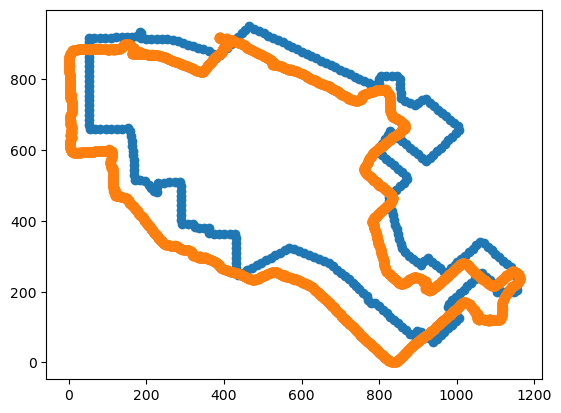

[[-1.06496335e+07 -1.06230267e+07]
 [ 3.46938431e+06  3.46815601e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 7.04256387e+00  2.42405153e-01 -1.06496335e+07]
 [-3.25118990e-01 -7.16565607e+00  3.46938431e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480287IND0_0281.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[0.07984031936127745, 0.0, 0.02789400278940028, 0.050505050505050504, 3.5988538681948423, 6.666666666666667, 0.07984031936127745, 0.025974025974025976, 3.98884239888424, 4.191919191919192, 0.038204393505253106, 6.666666666666667, 0.3992015968063872, 2.632034632034632, 2.577405857740586, 2.8936527952921396, 0.038314176245210725, 6.666666666666667, 0.11177644710578842, 0.0, 0.0, 0.03708386009270965, 4.095238095238095, 0.0, 1.2295409181636727, 1.6277056277056277, 2.6555090655509064, 3.229219143576826, 2.7204610951008648, 5.333333333333333, 0.07984031936127745, 0.0, 0.0, 0.025252525252525252, 3.8089780324737346, 6.666666666666667, 0.9820359281437125, 1.9134199134199135, 4.083682008368201, 3.7356902356902357, 0.0, 0.0, 0.7265469061876247, 1.4718614718614718, 4.105997210599721, 3.0348886086591005, 0.07279693486590039, 6.666666666666667, 0.47105788423153694, 4.311688311688312, 4.384937238493724, 2.553872053872054, 0.0, 0.0, 0.0, 0.040834442964935644, 0.08014571948998178, 0.22099447513812154, 

  0%|          | 0/2 [00:00<?, ?it/s]

[0.0447427293064877, 1.1626016260162602, 3.3454545454545452, 4.068126520681266, 4.223385689354275, 2.586826347305389, 2.7901234567901234, 2.903885480572597, 1.0406504065040652, 1.2614770459081837, 0.18518518518518517, 0.07570977917981073, 0.0, 0.0, 4.017897091722595, 4.0, 4.0, 4.0, 3.357766143106457, 1.1017964071856288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04206098843322818, 0.3305785123966942, 0.0, 0.049217002237136466, 4.235772357723577, 3.2808080808080806, 3.0948905109489053, 3.762652705061082, 3.2574850299401197, 3.1358024691358026, 2.9529652351738243, 3.048780487804878, 2.3073852295409183, 2.0185185185185186, 0.42902208201892744, 0.0, 0.0, 0.22818791946308725, 3.6991869918699187, 4.161616161616162, 2.0145985401459856, 3.1204188481675392, 3.720558882235529, 1.8271604938271604, 0.22085889570552147, 0.6910569105691057, 0.5349301397205589, 0.0, 0.0, 0.0, 0.6666666666666666, 1.1230425055928412, 1.3333333333333333, 1.3333333333333333, 1.3333333333333333, 1.905759162303665, 3.776447105788423, 4.10

____________________________________
['City', 'of', 'Houston', 'AREA', 'NOT', 'INCLUDED', 'Chimney', 'Rock', 'Diversion', 'Channel', 'D139', '00', '00', '480287', '0420D', 'Tributary', '13', '73', '132', '00', '0', 'G', 'Tributary', '17', '76', 'C161', '00', '00']
____________________________________
['_', '_', '7', '100', '00', '9', 'prod', 'Fondre', 'u', 'Diversion', 'Channel', 'D140', '00', '00', '480287', '0415', 'D', 'illow', 'Waterhole', 'Bayou', 'D112', '00', '00', 'ributary', '22', '68', 'C162', '00', '00', '7', '813', '3', '___']
____________________________________
['Tucker', 'Buyou', '480287', '0455', 'E', 'AREA', 'NOT', 'INCLUDED', 'City', 'of', 'Deer', 'Park', 'ributary', '1', '77', 'B112', '02', '00']
____________________________________
['City', 'of', 'Jacinto', 'City', 'AREA', 'NOT', 'INCLUDED', 'City', 'of', 'Galena', 'Park', 'AREA', 'NOT', 'INCLUDED', 'Panther', 'G112', '00', '00', '480287', '0430', 'D', 'C102', 'Plum', 'rook', '0', '00', '103', '00', '00', 'Tributary

____________________________________
['Tributary', '9', '36', '7', '1', '109', '00', '00', 'i', '2', 'Do', 'l', 'I', 'Litteg', '22', 'c', '2N', '2', 'Dry', '480287', '0155', 'E', '480287', '0160', 'E', 'T', 'L', '72', '00', 'e', '30', 'fess', 'N', 'Qg']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1798.000160101706 1314.499999784229, 2169 1314, 2168.617249552732 1029.999168127287, 1796.999839898294 1030.50000021577, 1798.000160101706 1314.499999784229)), POLYGON ((1796.999839898294 1030.50000021577, 1426 1031, 1426.382750447268 1315.000831872713, 1798.000160101706 1314.499999784229, 1796.999839898294 1030.50000021577)))
____________________________________
['Littie', 'e', 'Y', '480287', '0135D', 'Tributary', '42', '7', 'MK', '157', '00', '00', 'b', 'K1', '5000y', 'NN', 'utary', '37', '17', 'X', 'KIG', '2', '00', '00']
____________________________________
['WARKEN', '480287', '0130', 'Mound', 'Crook', 'K', '166', '00', '00', 'Fribaitars', '163', 'L',

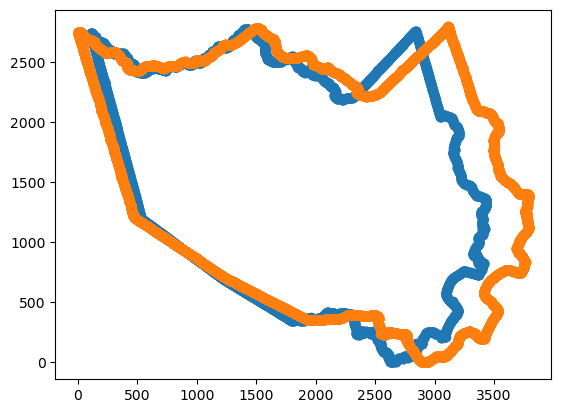

[[-1.07030653e+07 -1.05751366e+07]
 [ 3.54102777e+06  3.54055217e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 3.38704481e+01 -5.91650640e-01 -1.07030653e+07]
 [-1.25919484e-01 -2.99398181e+01  3.54102777e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480287IND0_0382.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[2.9490196078431374, 4.995555555555556, 4.449897750511248, 4.233618233618234, 4.932203389830509, 0.5972222222222222, 2.7946916471506635, 3.5555555555555554, 0.3137254901960784, 0.0, 0.0, 0.05555555555555555, 0.209366391184573, 0.2706552706552707, 2.507416081186573, 4.444444444444445, 0.34509803921568627, 4.174603174603175, 4.207792207792208, 4.375350140056023, 4.233333333333333, 4.3841807909604515, 0.08743169398907104, 4.444444444444445, 0.39215686274509803, 1.3821138211382114, 2.213675213675214, 4.579465541490858, 5.377777777777778, 1.6095842142353771, 0.0468384074941452, 2.2222222222222223, 0.23529411764705882, 0.0, 0.0, 2.683403068340307, 2.84297520661157, 4.383795309168444, 0.05932864949258392, 5.777777777777778, 0.25098039215686274, 0.691358024691358, 2.0467091295116773, 2.5935302390998594, 4.412831241283124, 3.032348804500703, 0.05308352849336456, 3.111111111111111, 0.3137254901960784, 0.0, 0.0, 0.0, 0.0, 0.0, 2.782201405152225, 0.0, 0.2823529411764706, 0.23529411764705882, 2.082

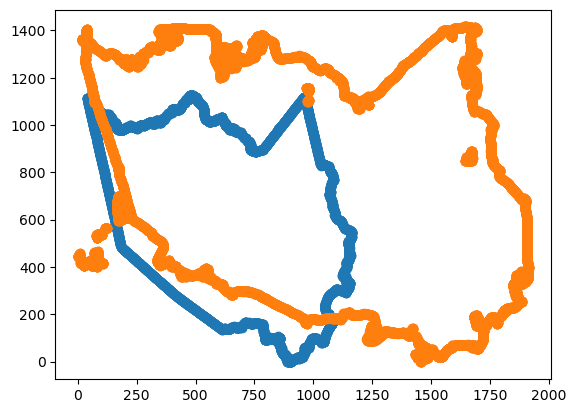

[[-1.06873162e+07 -1.03447457e+07]
 [ 3.62159247e+06  3.67052617e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 9.04118646e+01 -3.35412628e+00 -1.06873162e+07]
 [ 1.29146735e+01 -6.66332092e+01  3.62159247e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480287IND0_0985.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[0.0664451827242525, 0.0, 0.0, 3.1566265060240966, 4.6626746506986025, 4.708860759493671, 3.2974051896207586, 3.329243353783231, 1.793939393939394, 1.1522633744855968, 0.6933333333333334, 0.851063829787234, 1.164319248826291, 0.4, 0.08658008658008658, 0.0, 3.3333333333333335, 0.11074197120708748, 1.2912280701754386, 2.8, 2.3855421686746987, 2.179640718562874, 3.3248945147679323, 4.319361277445109, 4.4929292929292926, 4.850715746421268, 3.786008230452675, 3.111111111111111, 2.8368794326241136, 3.3615023474178405, 0.2222222222222222, 0.0, 0.0851063829787234, 1.1111111111111112, 1.3421926910299002, 1.3333333333333333, 1.3333333333333333, 2.2008032128514055, 2.914171656686627, 3.949367088607595, 3.241516966067864, 2.783333333333333, 3.1904761904761907, 3.4074074074074074, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 1.1774891774891776, 0.3574468085106383, 2.0, 0.0, 0.1003584229390681, 3.2962962962962963, 3.967871485943775, 3.18562874251497, 4.025316455696

____________________________________
['Berry', 'Bayou', 'T', 'C106', '00', '00', 'Tributary', '10', '12', 'C118', '00', '00', '30', '480287', '0440', 'D', 'C106', '01', '00', 'Berry', 'Creele', 'Tributary', '2', '00', 'C106', '0360', 'Tributary', '10', '77', 'Tributary', '3', '3', 'C123', '00', '00', '106', '08', '00', 'b', 'Halle', 'Road', 'A120', '00', '00', 'T', '480287', '0505D', 'My', 'of', 'Pearland', 'oT', 'ARE', 'INCLUDED']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((2912.497786080792 2743.270789625583, 2911.995920807826 3031.341456308027, 3290 3032, 3290.50047177064 2744.729203652841, 2912.497786080792 2743.270789625583)), POLYGON ((3290.50047177064 2744.729203652841, 3291 2458, 2912.995920807826 2457.341456308027, 2912.497786080792 2743.270789625583, 3290.50047177064 2744.729203652841)))
____________________________________
['City', 'of', 'Houston', 'AREA', 'NOT', 'INCLUDED', 'Chimney', 'Roch', 'Diversion', 'Channel', 'D139', '00', '00', 

____________________________________
['Tributar', 'ributar', 'g', 'P133', '02', '00', 'R', 'P130', '0', '02', 'Trivutary', '3', '19', 'P130', '03', '00', '480287', '0215E', 'Zay', 'P100', '000']
____________________________________
['Tributary', 'ip135', '56', '00', '480287', '0195D', '24', '97', '_Greens', 'Lriputars', 'P135', '00', '00']
____________________________________
['Lributary', '32', '23', 'P146', '00', '00', 'Hayg', 'ributary', '3460', 'e', '00', '00', '480287', '0190', 'D', '2', '2', 'G', '2']
____________________________________
['TR0', '480287', '0170', 'D', 'City', 'of', 'G', 'Jersey', 'Village', 'AREA', 'NOT', 'X', 'o', 'INCLUDED', '5', '7o', '52', 'Tributary', 'e', 'g', '18830', '00', 'gg', 'Z']
____________________________________
['P', '100', '55750', '3', 'T', '480287', '0', '165', 'D', 'O', 'a', 'e', 'o']
____________________________________
['Creck', 'Rock', 'Hollow', 'K160', '00', '00', '480287', '0145D']
____________________________________
['Q', 'bmovo', 'N',

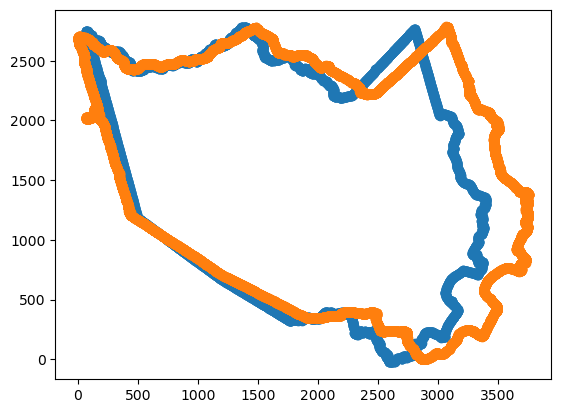

[[-1.07035168e+07 -1.05745665e+07]
 [ 3.54048463e+06  3.54028408e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 3.39700490e+01 -4.78624576e-01 -1.07035168e+07]
 [-5.28311553e-02 -2.97125444e+01  3.54048463e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480296IND0_0982.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[2.369146005509642, 2.6666666666666665, 2.6666666666666665, 2.7160493827160495, 3.1842105263157894, 4.0, 3.9896238651102465, 4.392156862745098, 3.6130718954248366, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 3.4517543859649122, 0.0, 0.11019283746556474, 0.0, 0.2595078299776286, 0.0, 0.0, 0.05128205128205128, 1.769130998702983, 1.7359477124183007, 3.1058823529411765, 4.249027237354086, 0.15261044176706828, 0.0, 0.03508771929824561, 6.666666666666667, 0.11019283746556474, 0.0, 0.0, 0.0, 0.05263157894736842, 4.064102564102564, 4.031128404669261, 4.8052287581699344, 3.189542483660131, 1.5719844357976653, 0.13654618473895583, 0.05649717514124294, 0.2807017543859649, 6.666666666666667, 0.0, 0.0, 0.0, 0.18518518518518517, 0.13157894736842105, 0.11538461538461539, 0.2230869001297017, 0.20392156862745098, 0.0784313725490196, 0.07782101167315175, 0.0, 0.0, 4.754385964912281, 6.666666666666667, 0.0, 0.0, 0.0, 2.0617283950617282, 1.9035087719298245, 2.4358974358974357, 2.9779507133

____________________________________
['ELN', 'po', 'R', 'A', 'T', '480296', '0015', 'C', 'CORPORATE', 'J']
____________________________________
['480296', '0005', 'B', 'x_', 'NI']
Assigning Points
[216. 493.   1.]


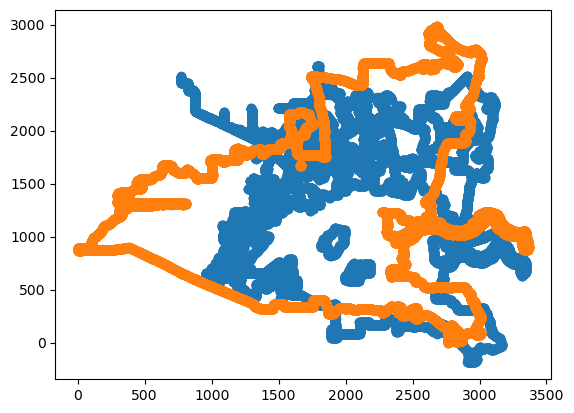

[[-5.77075561e+15 -2.00749180e+15]
 [ 3.01017620e+16  1.33242814e+17]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 9.96891076e+11 -3.51437452e+11 -5.77075561e+15]
 [ 2.73221329e+13  2.37466752e+13  3.01017620e+16]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480296IND0_0985.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[0.1111111111111111, 0.0, 0.0, 0.0, 0.06140350877192982, 4.1246105919003115, 4.068783068783069, 4.057068741893644, 4.124513618677042, 4.33015873015873, 4.226579520697168, 0.13859020310633213, 0.08743169398907104, 6.666666666666667, 0.10582010582010581, 0.0, 0.23841059602649006, 3.825545171339564, 3.973333333333333, 4.0, 4.666666666666667, 2.656290531776913, 4.477302204928664, 5.295238095238095, 3.1721132897603486, 0.0, 0.02185792349726776, 6.666666666666667, 0.1092896174863388, 0.0, 0.04415011037527594, 0.25157232704402516, 0.17660044150110377, 0.06230529595015576, 0.13756613756613756, 0.10376134889753567, 0.1556420233463035, 0.06349206349206349, 0.0, 0.0047789725209080045, 3.833879781420765, 6.666666666666667, 0.10666666666666667, 0.032719836400818, 3.5584988962472406, 3.127725856697819, 2.568888888888889, 1.482866043613707, 4.174603174603175, 0.383916990920882, 2.2412451361867705, 2.107936507936508, 0.14814814814814814, 0.0, 0.0, 0.0, 0.10416666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3

____________________________________
['City', 'of', 'Piney', 'P', 'Point', 'iidtery', '2', 'Piney', 'Point', 'Gully', '480296', '0115', 'D', 'Tributary', '22', '69', 'D124', '00', '00', 'Brays', 'Bayou', 'D100', '00', '00', 'Tributary', '20', '86', 'D142', '00', '00', 'Tributary', '21', '5', 'D122', '00', '00', 'Tributary', '20', '90', '19', '77', 'rributary', 'D120', '00', '00', 'Tributary', 'mw', 'd', 'a', 'on', '480296', '0150', 'D', 'Fondren', 'Diversion', 'I', 'Keegans', 'Channel', 'R', 'Bayou', 'D140', '00', '00', 'D118', '00', '00', 'ol', 'N', 'i']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((1444.759726226907 2457.72730448838, 1445.518277172958 2105.001114574566, 980.5182771729579 2104.001114574566, 979.7585543568395 2457.272224069639, 1444.759726226907 2457.72730448838)), POLYGON ((979.7585543568395 2457.272224069639, 979 2810, 1444 2811, 1444.759726226907 2457.72730448838, 979.7585543568395 2457.272224069639)))
____________________________

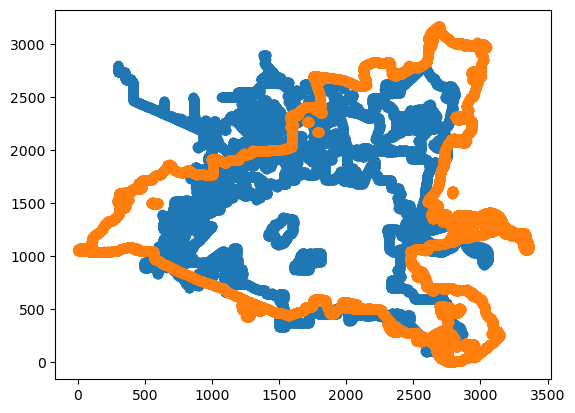

[[-3.13374008e+16 -3.56503655e+16]
 [ 1.03463790e+17  4.14132091e+17]
 [ 1.00000000e+00  1.00000000e+00]]
[[-1.14280994e+12  1.96666197e+12 -3.13374008e+16]
 [ 8.23180447e+13  8.08721378e+13  1.03463790e+17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480296IND0_0987.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[0.21333333333333335, 0.0, 0.38478747203579416, 3.962962962962963, 5.1655629139072845, 5.370716510903427, 5.4018445322793145, 4.838541666666667, 4.8125, 4.899598393574297, 1.8494623655913978, 0.0, 0.02237136465324385, 6.666666666666667, 0.11019283746556474, 0.0, 0.053691275167785234, 4.9753086419753085, 4.229580573951435, 4.722741433021807, 5.312252964426878, 5.390625, 5.286458333333333, 4.016064257028113, 4.086021505376344, 0.06168446026097272, 0.15894039735099338, 6.666666666666667, 0.1111111111111111, 0.0, 0.0, 0.0, 0.0706401766004415, 4.1993769470404985, 4.115942028985507, 5.083333333333333, 5.359375, 5.453815261044177, 5.405017921146953, 0.18979833926453143, 0.15011037527593818, 6.666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06851119894598155, 5.0625, 5.322916666666667, 4.658634538152611, 3.6702508960573477, 0.0743321718931475, 0.07657657657657657, 2.0, 4.62015503875969, 3.675, 2.6666666666666665, 2.6666666666666665, 3.3730684326710816, 3.763239875389408, 3.9578392621870884, 3

____________________________________
['City', 'of', 'N', 'Piney', 'Point', 'seummel', 'Creck', 'W156', '00', '00', 'AREA', 'L', '7', 'INCLUIDED', 'Piney', 'Point', 'Gl', '480296', '0115', 'D', '1rib', 'I', 'l', 'llm', 'T', 'Bravs', 'Bavou', 'D100', '00', '00', 'D', '142', '60', '006', 'Iributary', '2056', 'A']
____________________________________
['T', '21', '1RAIR', 'X', 'Butfalo', 'Bavou', 'o', 'Diten', '1100', '00', '00', 'RESFRVOIR', '480296', '0110', '1103', '00', '00', 'T', 'o', 'W', '2', '8', 'Tributary', 'D126', '00', '00', '1']
____________________________________
['Mason', '1675000', 's', 'Sy', '0', '9', '8', 'o', 'oy', '480296', '0135', 'i', 'BARKER', 'FRRPORATE', 'OMiTs']
____________________________________
['Groens', 'P100', '00', '00', '480296', '0095', 'E', 'Jordan', 'Gully', '10500', '00', 'Fun', 'ting', 'Bavou', 'i', 'ry', '11100', '00', '00', 'i', 'o']
____________________________________
['S', 'Hunting', 'Bayou', 'Tributary', '12', '05', '11100', '00', '00', '11115'

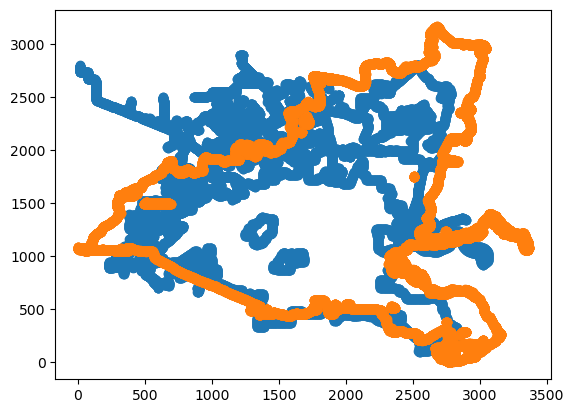

[[-1.06632859e+07 -1.05031606e+07]
 [ 3.53495705e+06  3.48904455e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 4.25073917e+01 -1.66872838e+01 -1.06632859e+07]
 [-1.21880797e+01 -3.48584008e+01  3.53495705e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480296IND0_1279.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[0.24338624338624337, 0.509090909090909, 0.23006535947712417, 0.3684210526315789, 0.37383177570093457, 2.15962441314554, 0.6853582554517134, 1.848133848133848, 2.384313725490196, 3.8297872340425534, 4.081799591002045, 5.3812375249501, 0.19047619047619047, 0.09302325581395349, 6.666666666666667, 0.0, 0.05656565656565657, 1.3071895424836601, 1.7280701754385965, 2.6666666666666665, 3.07981220657277, 2.6666666666666665, 2.6666666666666665, 3.3777777777777778, 2.6666666666666665, 3.4355828220858897, 2.69061876247505, 2.6666666666666665, 2.75968992248062, 4.0, 0.20105820105820105, 0.0, 1.1084967320261438, 2.6842105263157894, 4.0, 4.018779342723005, 4.274143302180685, 4.993564993564994, 3.7333333333333334, 3.120567375886525, 3.1411042944785277, 0.1437125748502994, 0.0, 0.0221483942414175, 6.666666666666667, 0.15873015873015872, 0.0, 1.7673202614379084, 5.043859649122807, 5.370716510903427, 4.178403755868545, 3.4890965732087227, 2.7953667953667956, 2.0862745098039217, 1.5602836879432624, 1.815

____________________________________
['480296', '0025', 'B', 'I_']
____________________________________
['kool']
____________________________________
['J', '480296', '0035', 'B']
____________________________________
['LAKE', '3', 'HOUSTON', '480296', '0040', 'B', '3', '_AA', 'SAVN', 'IV', 'E', 'INTO']
____________________________________
['4', 'L', 'Yo', 'ol', 'AE', 'MR', 'W', 'V', 'HOUSTON', '480296', '0020', 'B', 'A']
____________________________________
['2', 'R', 'o', 'Ory', '480296', '0015', 'B', 'Iﬁmi', 'ﬂi', 'i']
____________________________________
['w', 'l', 's', 'O', 'T', '480296', '0010', 'B', '5']
____________________________________
['o', '80296', '0005', 'B', 's']
Assigning Points
[225. 575.   1.]


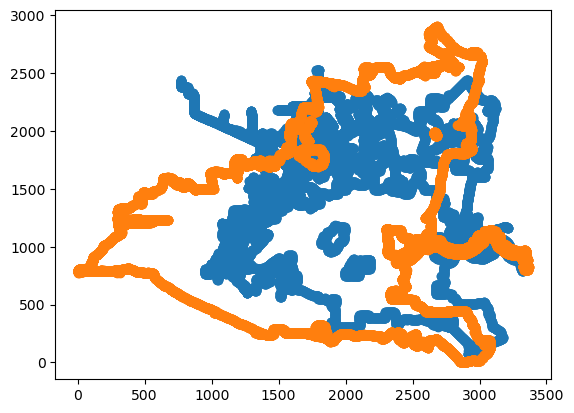

[[-4.87226204e+19 -1.93516256e+20]
 [ 3.95215071e+19  1.58620029e+20]
 [ 1.00000000e+00  1.00000000e+00]]
[[-3.83660931e+16  3.55288445e+16 -4.87226204e+19]
 [ 3.15576369e+16  2.91994229e+16  3.95215071e+19]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480304IND0_0182.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[0.15037593984962405, 0.09925093632958802, 0.8298368298368298, 1.125925925925926, 0.28940568475452194, 0.4740740740740741, 0.2550091074681239, 0.10256410256410256, 0.12030075187969924, 5.337078651685394, 4.827972027972028, 3.9703703703703703, 4.0, 2.431125131440589, 1.1147540983606556, 0.0, 1.4837092731829573, 0.5730337078651685, 2.6386946386946386, 2.6666666666666665, 2.6666666666666665, 2.741228070175439, 1.0273224043715847, 2.707692307692308, 0.10025062656641603, 0.0, 0.0, 1.3925925925925926, 3.693121693121693, 4.951781970649895, 5.333333333333333, 5.384615384615385, 0.10025062656641603, 0.08239700374531835, 0.2386946386946387, 1.3333333333333333, 1.4019607843137254, 2.844155844155844, 5.17304189435337, 0.15384615384615385, 0.12030075187969924, 4.01685393258427, 1.9785547785547786, 0.6814814814814815, 3.8066157760814248, 5.320553780617678, 5.158469945355192, 0.10256410256410256, 0.021645021645021644, 0.12179487179487179, 0.35751840168243953, 0.08771929824561403, 0.03454231433506045,

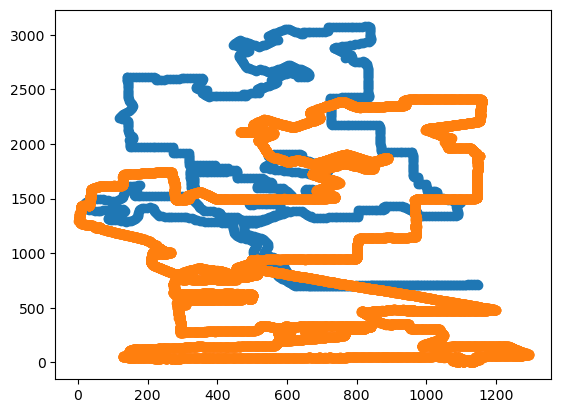

[[3.76908838e+14 5.21869016e+14]
 [1.01923745e+14 1.42609072e+14]
 [1.00000000e+00 1.00000000e+00]]
[[ 3.83087149e+10 -3.04262642e+11  3.76908838e+14]
 [ 1.07519363e+10  8.41519116e+10  1.01923745e+14]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480304IND0_1077.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

[0.21680216802168023, 4.229409228115567, 0.019464720194647202, 0.06130268199233716, 0.10683760683760683, 6.666666666666667, 0.15176151761517614, 0.30702889176369125, 0.22384428223844283, 0.0481663929939792, 1.9743589743589745, 6.666666666666667, 3.7181571815718155, 4.201811125485123, 5.294403892944039, 2.6863711001642034, 3.111111111111111, 0.0, 0.032520325203252036, 4.46916774471755, 0.1070559610705596, 0.043787629994526546, 0.07478632478632478, 6.666666666666667, 0.8, 6.622222222222222, 5.672977624784854, 4.2030456852791875, 3.1485943775100402, 2.6666666666666665, 0.8, 4.16982214572576, 4.918217710095883, 0.08032128514056225, 1.3333333333333333, 0.8592592592592593, 5.608720596672404, 5.714608009024253, 0.0963855421686747, 0.0, 3.348148148148148, 4.013769363166953, 4.009024252679075, 2.072289156626506, 6.666666666666667, 5.0814814814814815, 2.6666666666666665, 0.0, 0.0]
Highest Hierarchy: 2 in 4 contours
____________________________________
['N', 'l', 'FLOOD', 'HAZARD', 'BOUNDARY', 'M

  0%|          | 0/2 [00:00<?, ?it/s]

[0.0, 0.6704225352112676, 4.271154745208041, 2.3944055944055944, 0.0, 0.09732360097323602, 0.0, 3.5698924731182795, 1.3146853146853146, 0.0, 4.76595744680851, 1.656160458452722, 3.2725572697522205, 4.0, 4.042666666666666, 5.407407407407407, 1.4642356241234222, 0.0, 0.0, 0.0, 0.20050125313283207, 2.356940509915014, 1.0154277699859748, 0.12494172494172494, 0.0, 0.19753086419753085, 0.0, 1.5409069658719028, 0.5072261072261073, 0.010666666666666666, 3.3333333333333335, 0.041192411924119245, 0.07459207459207459, 0.0, 3.012111637704055, 0.0, 0.0, 1.6666666666666667, 0.04336043360433604, 4.979405034324943, 2.2090729783037477, 0.1895734597156398, 0.037037037037037035, 0.0, 1.6666666666666667, 0.06504065040650407, 0.14164742109314857, 1.834296724470135, 4.008425487098473, 0.04938271604938271, 0.0, 6.666666666666667, 0.01951219512195122, 0.0, 0.0, 3.357556608741443, 0.022222222222222223, 2.5]
Highest Hierarchy: 1 in 5 contours
____________________________________
['480304', '0015C', '0', 'PO', '

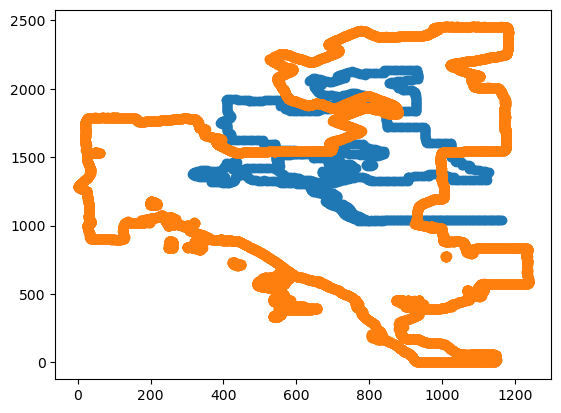

[[ 4.42569168e+17 -6.24319172e+17]
 [-4.48034242e+17  5.98619828e+17]
 [ 1.00000000e+00  1.00000000e+00]]
[[-2.83069339e+14 -3.60936539e+14  4.42569168e+17]
 [ 2.77700735e+14 -3.26731096e+14 -4.48034242e+17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\480307IND0_0686.jpg


  0%|          | 0/2 [00:00<?, ?it/s]

[2.5107344632768362, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.674264007597341, 4.0, 1.6836158192090396, 4.0134228187919465, 5.231481481481482, 0.03065134099616858, 0.03798670465337132, 6.666666666666667, 3.8689265536723165, 0.38222222222222224, 0.0, 0.0, 0.0721747388414055, 5.333333333333333, 0.022598870056497175, 0.0, 0.0, 0.007407407407407408, 4.938271604938271, 6.666666666666667, 0.022598870056497175, 0.04971751412429379, 0.6175438596491228, 3.837037037037037, 0.11396011396011396, 6.666666666666667, 0.020338983050847456, 0.0, 0.0, 0.04419889502762431, 3.9468186134852803, 6.666666666666667, 2.8940568475452197, 3.0375275938189845, 2.724380318165002, 2.707070707070707, 2.621212121212121, 0.11965811965811966, 0.10335917312661498, 0.0, 0.050314465408805034, 0.04040404040404041, 4.962962962962963, 5.36952380952381, 0.20671834625322996, 0.24135393671817512, 0.8908620051794303, 0.0, 0.0, 0.0, 0.10335917312661498, 0.01177336276674025, 1.115797262301147, 0.131313131313131

  0%|          | 0/6 [00:00<?, ?it/s]

[0.04329004329004329, 2.356902356902357, 4.222222222222222, 5.0476190476190474, 4.743589743589744, 0.3564356435643564, 0.12944983818770225, 3.8533333333333335, 4.063492063492063, 4.427184466019417, 4.743589743589744, 4.541254125412541, 4.233009708737864, 1.2168284789644013, 0.12944983818770225, 0.19801980198019803, 0.03766478342749529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0641025641025641, 4.1066666666666665, 4.1294498381877025, 0.92, 0.546031746031746, 0.1282051282051282, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1282051282051282, 2.8627450980392157, 3.792880258899676, 4.0, 4.114285714285714, 0.026143790849673203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021645021645021644, 4.133333333333334, 2.7538940809968846, 0.39057239057239057, 3.128205128205128, 2.466666666666667, 2.912621359223301, 2.7466666666666666, 2.895238095238095, 2.9358974358974357, 2.9773462783171523, 3.036303630363036, 0.22006472491909385, 0.0, 0.0, 0.0, 0.022684310018903593, 0.0, 0.03908794788273615, 0.0, 0

____________________________________
['N', 'Village', 'of', 'Quinta', 'na']
____________________________________
['City', 'of', 'Freeport']
____________________________________
['9', '000', '0', '7']
____________________________________
['o', 'ad', '0', '0']
____________________________________
['Ox', '00', 'O', 'V', 'by']
____________________________________
['Q', 'T', '2', '8']
____________________________________
['y', '8']
____________________________________
['7']
____________________________________
['23']
____________________________________
['e', 'g', 'f']
____________________________________
['Q', 'o', '00', 'O', 'b', 'Vilia', 'e', 'of', 'Jones', 'reek']
____________________________________
['Brazoria', 'CTty', 'of', '7', 'b', 'é', 'Ji']
____________________________________
['1', 'Qo', 'o']
____________________________________
['Q0', 'RO', 'o', '00', '090']
____________________________________
['o', 'o', 'O', 'V']
____________________________________
['i', 'llu', 'gcof', 'Oyst

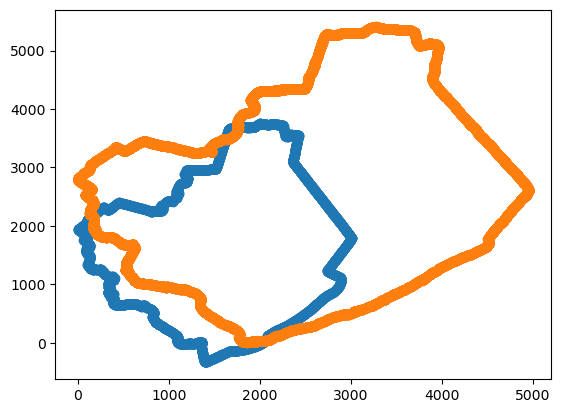

[[ 9.14248540e+08 -2.66864571e+09]
 [ 1.11875836e+09 -3.20154877e+09]
 [ 1.00000000e+00  1.00000000e+00]]
[[-3.46273727e+05 -3.29485371e+05  9.14248540e+08]
 [-4.17542006e+05  3.97247887e+05  1.11875836e+09]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48071CIND0A.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[0.3157894736842105, 2.3591331269349847, 2.4510978043912175, 1.89612097304405, 0.0, 0.0, 0.05217391304347826, 0.3157894736842105, 0.3157894736842105, 1.475748194014448, 2.802395209580838, 1.4174884944115713, 0.0, 0.0, 0.28405797101449276, 0.3157894736842105, 0.3157894736842105, 2.546955624355005, 2.0439121756487024, 0.6916502301117686, 0.0, 0.0, 0.12173913043478261, 0.3157894736842105, 0.3157894736842105, 1.5098039215686274, 0.2554890219560878, 0.6890203813280736, 0.0, 0.0, 0.05217391304347826, 0.3157894736842105, 0.3157894736842105, 1.8565531475748194, 2.0838323353293413, 0.8625904010519395, 0.34782608695652173, 0.18181818181818182, 0.07536231884057971, 0.17543859649122806, 0.3157894736842105, 1.6594427244582044, 2.44311377245509, 1.8750821827744906, 0.0, 0.0, 0.05217391304347826, 0.3157894736842105, 0.3157894736842105, 0.5923632610939112, 0.2155688622754491, 0.05259697567389875, 0.34782608695652173, 1.1111111111111112, 0.24347826086956523, 0.17543859649122806, 0.3157894736842105, 1.6

GEOMETRYCOLLECTION (POLYGON ((222 10349, 12000 10349, 12000 0, 222 0, 222 10349)))
Failure! Results will be inaccurate due to line segment on Tile Boundary not being identified
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48157CIND0.tif


  0%|          | 0/5 [00:00<?, ?it/s]

[0.22939068100358423, 0.008281573498964804, 0.5020576131687243, 0.6333333333333333, 0.0, 0.23045267489711935, 0.8198757763975155, 0.0, 0.0, 0.0, 0.10139416983523447, 0.5490196078431373, 0.0, 0.045548654244306416, 3.6378600823045266, 0.5666666666666667, 0.11382113821138211, 0.08832807570977919, 0.11347517730496454, 0.12269938650306748, 0.0, 0.0, 0.22813688212927757, 1.1764705882352942, 0.14336917562724014, 4.082815734989648, 4.329218106995885, 4.325, 4.235772357723577, 4.392894461859979, 3.620795107033639, 4.065439672801636, 2.691358024691358, 0.2611683848797251, 0.0, 0.0, 0.14336917562724014, 0.062111801242236024, 0.46502057613168724, 0.275, 0.2764227642276423, 0.5726227795193313, 0.06116207951070336, 0.12269938650306748, 0.0, 0.20618556701030927, 2.2712294043092522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.908745247148289, 0.0, 0.0, 0.0, 0.0, 2.6666666666666665, 2.6991869918699187, 0.03292181069958848, 0.012422360248447204, 0.0, 0.0, 0.0, 0.07604562737642585, 0.3921568

____________________________________
['4815760220', '1', '3', '97', 'CITY', 'OF', 'ROSENBERG', '2']
____________________________________
['4815700215', '1', '3', '91', 'Q6', 'e', 'oo', 'qaali']
____________________________________
['48157C0285', '1', '600', 'SCALE', 'MAP', 'PANEL', 'MAP', 'N', 'ER', '4815700283', 'HARR', 'S', 'COUNTY', 'BRAZORIA', 'COUNTY', 'e']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((9975 4667.727689837118, 9975 4215, 9182 4215, 9182 4667.272883688919, 9975 4667.727689837118)), POLYGON ((9182 4667.272883688919, 9182 5121, 9975 5121, 9975 4667.727689837118, 9182 4667.272883688919)))
____________________________________
['4815700280', 'K', '4', '20', '00', 'CITY', 'OF', 'HOUSTON', 'Creek', 'Clear', 'S']
____________________________________
['4815760255', '4815700260', '1', '3', '81', 'Q', '173791', 'Creek', 'S', 'First', 'I', 'Colony', 'MISSOURI', 'CITY', 'OF', 'CITY', 'MUD', 'Fort', 'Bend', 'No', '2', 'Stafford', 'Run', 'B', 'M

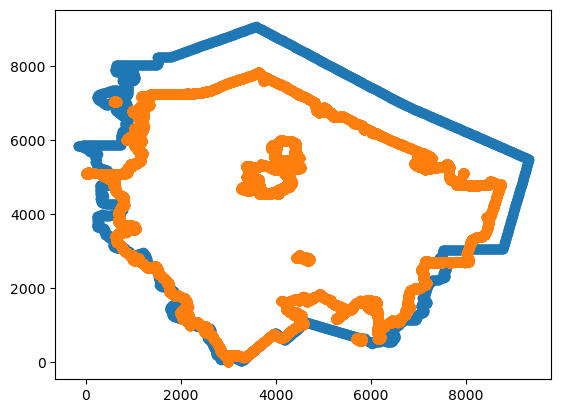

[[-1.07042447e+07 -1.06120449e+07]
 [ 3.47908105e+06  3.47905049e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 9.02415500e+00  7.72078998e-02 -1.07042447e+07]
 [-2.99035003e-03 -8.61868973e+00  3.47908105e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48157CIND0A.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[0.09950248756218906, 0.7961990497624406, 0.09174311926605505, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09950248756218906, 0.2000500125031258, 1.0581039755351682, 2.6666666666666665, 1.6453900709219857, 2.6666666666666665, 1.5855855855855856, 1.6876006441223832, 0.2328042328042328, 0.09950248756218906, 0.7721930482620655, 0.12844036697247707, 0.9887005649717514, 0.41904761904761906, 1.180952380952381, 0.36036036036036034, 0.7342995169082126, 0.31746031746031744, 0.09950248756218906, 0.23105776444111029, 0.23853211009174313, 2.171589310829817, 1.3429256594724222, 2.4571428571428573, 1.3693693693693694, 1.4492753623188406, 0.31746031746031744, 0.09950248756218906, 0.08602150537634409, 0.5749235474006116, 0.6723646723646723, 0.8169014084507042, 0.05714285714285714, 2.3063063063063063, 1.4943639291465378, 0.48677248677248675, 0.0, 0.6961740435108777, 0.0, 1.4891774891774892, 2.4827586206896552, 0.20952380952380953, 3.7117117117117115, 2.6988727858293076, 0.5291005291005291, 0.09950248756218906, 0.2

GEOMETRYCOLLECTION (POLYGON ((8398 4391.27274587834, 8398 389, 402 389, 402 4390.72725412166, 8398 4391.27274587834)), POLYGON ((402 4390.72725412166, 402 8394, 8398 8394, 8398 4391.27274587834, 402 4390.72725412166)))
Assigning Points
[9.650e+02 2.464e+03 1.000e+00]


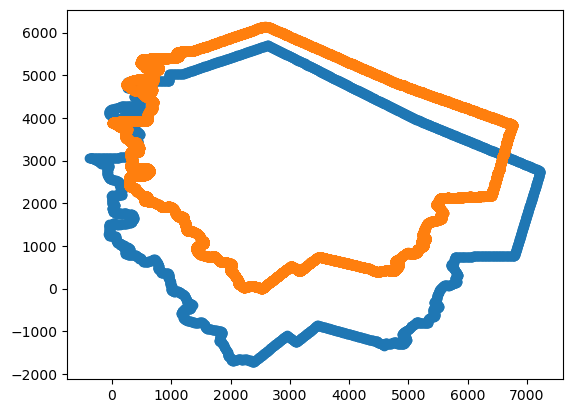

[[-1.07072961e+07 -1.05897825e+07]
 [ 3.48412735e+06  3.47798222e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 1.13452047e+01  2.87218512e-01 -1.07072961e+07]
 [-5.93273322e-01 -1.05525318e+01  3.48412735e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48157CIND0B.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[1.41991341991342, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.4828592268417213, 4.404040404040404, 2.6842105263157894, 0.0, 0.2597402597402597, 0.14746543778801843, 0.13658536585365855, 0.298989898989899, 0.0, 0.22727272727272727, 0.07017543859649122, 0.0, 0.017429193899782137, 1.3304157549234135, 0.4444444444444444, 0.3157894736842105, 0.3333333333333333, 0.45021645021645024, 0.38095238095238093, 0.13008130081300814, 0.20202020202020202, 1.7391304347826086, 2.4318181818181817, 2.7415204678362572, 2.898550724637681, 2.1350762527233114, 0.1925601750547046, 0.5050505050505051, 0.21052631578947367, 0.3333333333333333, 0.4155844155844156, 1.130568356374808, 0.16910569105691056, 0.32323232323232326, 2.898550724637681, 2.8257575757575757, 2.8210526315789473, 2.898550724637681, 2.047930283224401, 0.0, 0.0, 0.14619883040935672, 0.3333333333333333, 0.2597402597402597, 0.0, 0.09

____________________________________
['Effective', 'Date', 'December', '21', '2017', 'April', '2', '2014', 'April', '2', '2014', 'April', '2', '2014', 'April', '2', '2014', 'April', '2', '2014']
____________________________________
['FIRM', 'Panel', 'Dates', 'For', 'Effective', 'Date', 'Panel', 'April', '2', '2014', '0130L', 'April', '2', '2014', '0135L', '0140L', 'April', '2', '2014', 'April', '2', '2014', '0145L', 'April', '2', '2014', '0165L', 'April', '2', '2014', '0200M']
____________________________________
['Panel', '0040L', '0045L', '0060L', '0070L', '0080L', '0085L']
____________________________________
['101', 'SId', 'INFNIAOHJNI', 'NOAVE', 'SNVYOI3M', '1SIM', 'L', '10141813', 'ALTLN', 'TVIDINNA', 'IAOYED', 'NVO3d', '9l', 'L', '1011', 'SIa', 'ALTILN', 'TVISINNIA', 'N3G', 'NOISSIN', 'Gl', '10M', 'LSI', 'ALIMLN', 'TVJIDINAN', '3DAIGSONIM', '14', 'b', 'CP', 'LOIELSIA', 'ALIMLN', 'TVdIDSINAIN', 'ALNNOOD', 'aN3', 'g', '1H04', 'l', 'b', '101181', 'ALTILN', 'TYIDINNN', 'ALNNOD', 'AN

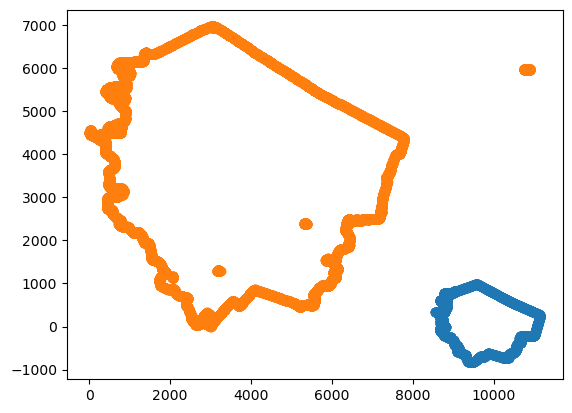

[[-8.79567686e+11  4.86774583e+11]
 [ 2.74927840e+12 -1.52231857e+12]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 1.32013746e+08 -1.34453381e+08 -8.79567686e+11]
 [-4.12714683e+08 -4.20387315e+08  2.74927840e+12]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48201CIND0.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.06349206349206349, 1.6242424242424243, 4.176100628930818, 1.6636085626911314, 0.9847494553376906, 1.3968253968253967, 2.1728395061728394, 2.1183800623052957, 2.0987654320987654, 2.84375, 2.806201550387597, 1.9506172839506173, 2.8623853211009176, 3.144186046511628, 0.3105022831050228, 1.054263565891473, 0.09049773755656108, 1.1111111111111112, 0.07662835249042145, 2.888888888888889, 3.1651090342679127, 3.074074074074074, 2.2554517133956384, 4.30188679245283, 4.18348623853211, 4.444444444444445, 4.333333333333333, 4.320987654320987, 4.224299065420561, 4.197530864197531, 4.260416666666667, 4.170542635658915, 3.740740740740741, 3.0458715596330275, 1.4883720930232558, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18518518518518517, 3.3021806853582554, 2.9382716049382718, 3.0654205607476634, 3.169811320754717, 4.220183486238532, 3.747276688453159, 3.9761904761904763, 3.8271604938271606, 2.9158878504672896, 2.814814814814815, 3.1979166666666665, 3.4263565891472867, 3.506172839506173, 3.0458715

Highest Hierarchy: 2 in 110 contours
____________________________________
['T', '482010109', 'LOR', 'LAKE', 'ITY', 'OF', 'ZJ', 'JIILLAGE', 'N', '7', 'OF', 'W', 'SAU', 'Z']
____________________________________
['_', '482011090', 'K', 'Bayou', '00', '00', 'TAY', 'CITY', 's', 'NAS', 'B', 'CITY', 'OF', 'G', 'P', 'NEST', 'WEBSTER']
____________________________________
['4820101070', 'K', 'Cow', '07', '7', 'Cedar', 'Gully', 'A118', '00', '00', 'Trzbutary', '10', '08', 'tos', 'Clear', 'Creek', 'AI11', '00', '00']
____________________________________
['482010', '065', 'K', 'v', 'Tributary', '0', '16', 'to', 'Turkey', 'Creek', 'd', '4119', '02', '00', '1D', 'CITY', 'OF', 'FRIENDSWOOD', 'Clear', 'Creek', 'A100', '00', '00', 'CITY', 'OF', 'LEAGUE', 'CITY']
____________________________________
['8201C1045', 'K', 'CITY', 'OF', 'PEARLAND', 'BRAZORIA', 'COUNTY', 'GALVESTON', 'COUNTY']
____________________________________
['48201C1105', 'J', 'CITY', 'OF', 'LA', 'PORTE', 'CITY', 'OF', 'SEABROOK']
_____

____________________________________
['280', 'QUI', 'NUUDIUN', '100645', '48201C0665', 'K', '9', 'SPRII', 'I', 'YV', 'AI', 'LEY', 'CITY', 'OF']
____________________________________
['482010755', '48201C0760', 'N', '0', 'BAYTOWN', 'CITY', 'OF', '2', 'e', 'Gully', 'Q114', '00', '00', '2', '48201C0765', '48201G0770', '15', '00200', 'JITY', 'OF', 'BAYTOWN', 'P', 'y', 'i', 'H', 'CCITY', 'OF', 'BAYTOWN', '4820100955', '482010960', 'SO', 'g', 'ER', 'Q100', '00', '00', 'edar', 'Bayou', 'Island', '2']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((9878 6651.273103805333, 9878 5751, 8824 5751, 8824 6650.727413926999, 9878 6651.273103805333)), POLYGON ((8824 6650.727413926999, 8824 7552, 9878 7552, 9878 6651.273103805333, 8824 6650.727413926999)))
____________________________________
['482010735', 'K', '01000000', '2']
____________________________________
['48201C0730', 'J', '103002', 'PACIF', '4820160740', 'RIVER', 'S', 'ahy', 'N', '_', '48201G0330', 'Tu', 'ker

____________________________________
['4820100', '85', 'J', 'S', 'Tri', 'Garners', 'Bayou', 'P130', '00', '00', 'CITY', 'OF', 'zyou', 'HUMBLE', '10', '10', 'Tributary', '8', '19', 'to', '1', 'Garners', 'Bayou', 'De', 'P130', '03', '00']
____________________________________
['4820100480', 'J', 'CITY', 'OF', 'HOUSTON', 'Reinhardt', 'B', 'P130', '05', 'Tributary', '26', '6', 'Greens', 'Bayo', 'P140', '00', '0']
____________________________________
['4820100460', 'J', 'P155', '00', '00']
____________________________________
['4820100455', '160435', 'North', 'Fork', 'Tributary', '1', '95', 'to', 'North', 'Fork', 'Greens', 'Bayou', 'Greens', 'Bayou', 'P145', '00', '00', 'P145', '03', '00', 'Tributary', '32', '23', 'RN', 'Ba', 'oa']
____________________________________
['482010430', 'K', '4820', '2', 'HOUSTON', 'CITY', 'OF', 'Cppress', 'Creck', 'Gree']
____________________________________
['4820100410', 'Dry', 'Creek', 'Q', 'K145', '00', '00', '5', '37', '1', 'to', 'Cypress', 'Creek', 'K152',

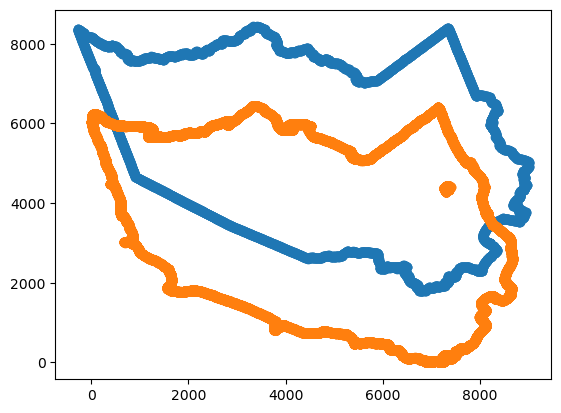

[[-1.06897938e+07 -1.05570248e+07]
 [ 3.56193547e+06  3.55905760e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 1.29202982e+01 -3.49257923e-01 -1.06897938e+07]
 [-2.80058034e-01 -1.32031707e+01  3.56193547e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48201CIND0A.tif


  0%|          | 0/5 [00:00<?, ?it/s]

[1.8333333333333333, 1.1382488479262673, 1.130568356374808, 1.4946236559139785, 1.8064516129032258, 0.5199692780337941, 1.5906298003072197, 1.6643625192012288, 1.8986175115207373, 3.3617511520737327, 2.589861751152074, 2.172811059907834, 2.751920122887865, 2.065284178187404, 2.675115207373272, 2.327188940092166, 2.425499231950845, 2.706605222734255, 2.182795698924731, 2.7772657450076803, 1.556067588325653, 0.7903225806451613, 2.133640552995392, 1.1428571428571428, 2.2211981566820276, 2.7104454685099846, 1.6797235023041475]
Highest Hierarchy: -1 in 25 contours
____________________________________
['i', 'e', 'sn', 'P', 'ca', 'e', 'T', '11', 'e']
____________________________________
['UMBER', 'LE', 'MAP', 'L', 'a1', 'of', 'wn', '00', '00', 'Creek', 'y', 'of', 'town', '4', 'F200', 'Galvesto', 'ena', '1C11']
____________________________________
['EL', '5L', '5L', '2100', '00', '0', 'edar', 'Bt', 'zyt', 'i', '10', '00', 'Ditch', 'L', '3', '2', 'o7', 'i', 'F2i', 'Little', 'C', 'Cit', '4', 'Ci

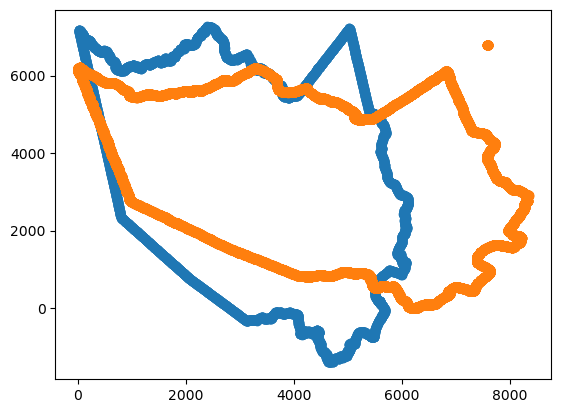

[[-1.07054716e+07 -1.04251739e+07]
 [ 3.51107587e+06  3.48616254e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 2.73888712e+01  1.93682439e-01 -1.07054716e+07]
 [-2.43436890e+00 -1.37190450e+01  3.51107587e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48201CIND0B.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[0.14814814814814814, 0.0, 0.17886178861788618, 2.0928270042194095, 2.566666666666667, 2.634920634920635, 2.8333333333333335, 2.8376068376068377, 2.183333333333333, 3.3413654618473894, 3.606837606837607, 2.847736625514403, 2.85, 2.880658436213992, 3.3833333333333333, 3.5443037974683542, 2.4390243902439024, 2.3045267489711936, 2.8860759493670884, 0.28858024691358025, 0.20765027322404372, 0.8666666666666667, 1.9753086419753085, 2.3628691983122363, 3.1666666666666665, 3.292181069958848, 3.1769547325102883, 3.729957805907173, 3.5833333333333335, 3.5121951219512195, 3.9662447257383966, 3.0833333333333335, 3.8, 3.3833333333333333, 3.6666666666666665, 3.1333333333333333, 2.95, 2.8333333333333335, 2.783333333333333, 0.08265107212475634, 0.1523809523809524, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.06837606837606838, 2.9, 2.859437751004016, 2.923076923076923, 2.8641975308641974, 3.0166666666666666, 3.6872427983539096, 2.897119341563786, 3.3675213675213675, 3.317073170731707, 2.337448559670782, 0.16666666

Highest Hierarchy: 0 in 158 contours
____________________________________
['GALVESTON', 'COUNTY', 'CITY', 'OF', 'LEAGUE', 'AREA', 'NOT', 'INCLUI', '48201C1150L']
____________________________________
['CITY', 'OF', 'ELLAGO', 'CITY', 'OF', 'TAYLOR', 'LAKE', 'VILLAGE', '48201C1095L', 'GALVESTON', 'COUNTY']
____________________________________
['48201', 'C1090l', 'CITY', 'OF', 'NASSAU', 'BAY', 'CITY', 'OF', 'WEBSTER']
____________________________________
['AN', 'b', '3201C1070L']
____________________________________
['48201C1065L', 'CITY', 'OF', 'FRIENDS', 'AREA', 'NOT', 'INCLL']
____________________________________
['48201C1045L']
____________________________________
['48201C1040L']
____________________________________
['FORT', 'BEND', 'f', 'BRAZOS', 'COUNTY', 'COUNTY', '48201C1025L']
____________________________________
['CITY', 'OF', 'PASADENA', '48201C1105L', '4', 'P', 'CITY', 'OF', 'SEABROOK', '48201C1125L', 'CHAMBERS', 'COUNTY', 'N']
Found too many names! Splitting along longest side

____________________________________
['S', '4', 'N', 'I', '43201C0680L']
____________________________________
['E101', 'Little', 'Oak', 'Bi', '48201C', '06601', '00', '00', '00', 'Oak', 'Bayou']
____________________________________
['117', '00', '00', 'ole', 'Creek', 'AT', '201', 'G0655L', 'E16', 'White', 'ITY_OE']
____________________________________
['_', 'Ei', 'C', '48201C0635L', 'CITY', 'OF', '1']
____________________________________
['48201', 'C0630L']
____________________________________
['4820', '1C0610L']
____________________________________
['AN', '48201C0605LC', 'N']
____________________________________
['48201C0585L', 'U101', '00', '00', 'South', 'Mayde', 'Creek']
____________________________________
['48201', '0580L', 'OF', 'KATY', 'TINCLUDED']
____________________________________
['48201C0565L', 'LIBERTY', 'COUNTY']
____________________________________
['48201C0545L']
____________________________________
['48201C0540L']
____________________________________
['0', 'CITY', 'O

____________________________________
['48201C0075L']
____________________________________
['48201C0050L', '48201C0045L']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((3151.128654636681 662.0487816687573, 2671.908888994929 651.0666620394671, 2659.437967479321 1195.252328175081, 3151.128654636681 662.0487816687573)), POLYGON ((2659.437967479321 1195.252328175081, 2647 1738, 3605.442484632636 1759.964306939498, 3630.351373627565 673.0309689789651, 3151.128654636681 662.0487816687573, 2659.437967479321 1195.252328175081)))
Assigning Points
[1.077e+03 3.028e+03 1.000e+00]


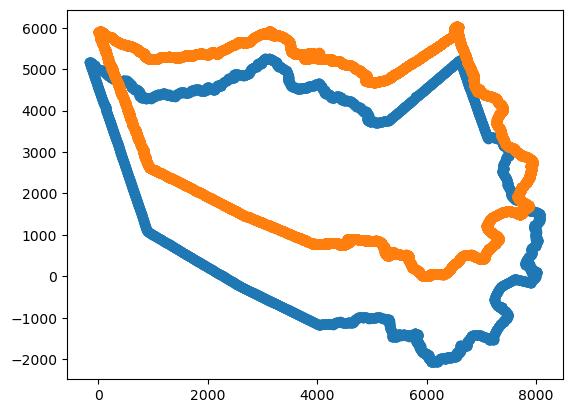

[[-1.07037913e+07 -1.05311577e+07]
 [ 3.52696432e+06  3.53549092e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 1.66795788e+01  6.88652910e-01 -1.07037913e+07]
 [ 8.23825618e-01 -1.38228925e+01  3.52696432e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48201CIND0C.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[0.08791208791208792, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21940928270042195, 2.1471861471861473, 2.570281124497992, 0.03333333333333333, 0.0, 0.0, 0.31853417899929526, 0.6666666666666666, 1.5609756097560976, 2.786324786324786, 2.49789029535865, 2.5166666666666666, 3.154471544715447, 3.1965811965811968, 2.9076305220883536, 1.7301587301587302, 2.406926406926407, 3.220779220779221, 2.130081300813008, 2.8333333333333335, 2.9794238683127574, 3.1223628691983123, 1.9833333333333334, 3.021097046413502, 0.2771855010660981, 0.12, 0.6178861788617886, 0.9572649572649573, 0.6244725738396625, 1.9578059071729959, 3.1967871485943773, 3.1452991452991452, 0.8780487804878049, 0.8253968253968254, 2.8034188034188032, 1.631578947368421, 2.2008032128514055, 2.45, 3.216666666666667, 2.852320675105485, 3.02880658436214, 3.0256410256410255, 0.056919245819992886, 0.08247422680412371, 0.2601626016260163, 2.341880341880342, 2.278481012658228, 2.8666666666666667, 3.2845528455284554, 2.12658227848101

Highest Hierarchy: 0 in 124 contours
____________________________________
['GALVESTON', 'COUNTY', 'CITY', 'OF', 'LEAGUE', 'AREA', 'NOT', 'INCLUL', '48201C1150L']
____________________________________
['CITY', 'OF', 'ELLAGO', 'CITY', 'OF', 'TAYLOR', 'LAKE', 'VILLAGE', '48201C1095L', 'GALVESTON', 'COUNTY']
____________________________________
['48', '230', 'I', 'Cﬁ_', 'CITY', 'OF', 'NASSAU', 'BAY', 'CITY', 'OF', 'WEBSTER']
____________________________________
['48201C1070h', 'sWOOD', 'JUDED']
____________________________________
['48201C1065L', 'ITY', 'OF', 'FRIENDS', 'AREA', 'NOT', 'INCLI', 'o']
____________________________________
['48201C1045L']
____________________________________
['FORT', 'BEND', 'I', 'BRAZOS', 'COUNTY', 'COUNTY', '48201C1025L', '48201C1040L']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((5178.000234990316 6713.981771465462, 4466.000000000001 6701, 4456.100210800374 7243.965361487244, 5171 7257.000000000001, 5178.000234990316 6713.

____________________________________
['4820', '1C0610L']
____________________________________
['48201C0605L', 'Wd']
____________________________________
['48201C0585L', 'U161', '00', '00', 'South', 'Mayde', 'Creek', '48201C0595L', 'T', '101', '00', 'Zzzna']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((2118.495662528197 4465.004728669129, 2106.969903626999 5009.020548805657, 2578.969903626999 5019.020548805657, 2590.495417519434 4475.016293082749, 2118.495662528197 4465.004728669129)), POLYGON ((2590.495417519434 4475.016293082749, 2602.000000000001 3932, 2130.000000000001 3922, 2118.495662528197 4465.004728669129, 2590.495417519434 4475.016293082749)))
____________________________________
['48201C0565L', 'LIBERTY', 'COUNTY']
____________________________________
['8201', '0545L', 'Q']
____________________________________
['48201', '00540']
____________________________________
['CITY', 'OF', 'HOUSTON', '48201C0520L']
__________________________________

____________________________________
['I', 'MONTGOMERY', 'COUNTY', '48201C0185L', 'u']
____________________________________
['WALLER', 'COUNTY', '48201C0180L']
____________________________________
['w', 'M']
____________________________________
['LIBERTY', 'COUNTY', '48201C0140L', 'a']
____________________________________
['MONTGOMERY', 'COUNTY', '48201C0120L', '7']
____________________________________
['48201C0090L']
____________________________________
['48201C0065L', '48201C0070L', 'F']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((4090.017932716448 1236.038806398393, 3622.32606284658 1227.044731977819, 3612 1764, 4080 1773, 4090.017932716448 1236.038806398393)), POLYGON ((4080 1773, 4548 1782, 4558.32606284658 1245.044731977819, 4090.017932716448 1236.038806398393, 4080 1773)))
____________________________________
['P', 'NUMBER', '0150L']
____________________________________
['MAF', '48201', 'C']
____________________________________
['48201C0125L

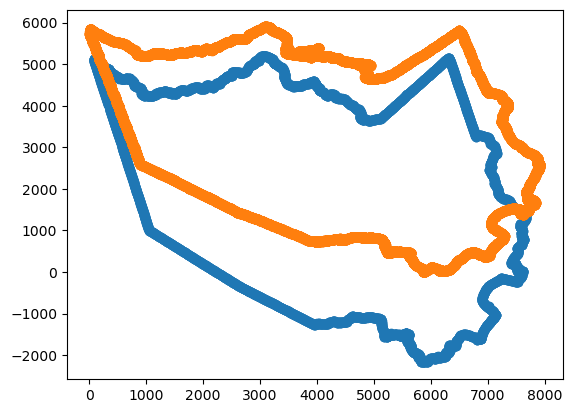

[[-1.07069304e+07 -1.05236462e+07]
 [ 3.52651249e+06  3.53643959e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 1.77086110e+01  8.24069635e-01 -1.07069304e+07]
 [ 9.59140300e-01 -1.34812670e+01  3.52651249e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48201CIND0D.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[0.55, 1.191111111111111, 0.8877777777777778, 0.4116666666666667, 0.8972222222222223, 0.39944444444444444, 0.8855555555555555, 2.585, 0.9727777777777777, 1.5083333333333333, 1.5905555555555555, 1.6316666666666666, 1.3494444444444444, 1.613888888888889, 0.265]
Highest Hierarchy: -1 in 7 contours
____________________________________
['TEXAS', 'CITY', 'OF', 'FRIENDSWOOD', 'AREA', 'NOT', 'INCLUDED', 'Mng', 'AND', 'INCORPORATED', 'AREAS', 'CITY', 'OF', 'WEBSTER', 'DN', 'NG', '0a', 'MTTXY', 'MTY', 'L', 'MATTT', 'MATTX', 'I', 'I']
____________________________________
['CI11L', 'Y', 'U', 'DIANFURLD', '00', 'S', '0', 'SOUT', 'H', 'fo', 'US', 'ToN', 'PANEL', 'NOT', 'PRINTED', 'AREA', 'OUTSIDE', 'COUNTY', 'BOUNDARY', 'ITTY', 'OF', 'SHOREACRES', 'CITY', 'OF', 'MISSOURI', 'CITY', 'MW', 'p', 'PANEL', 'NOT', 'PRINTED', 'NO', 'SPECIAL', 'FLOOD', 'HAZARD', 'AREAS', 'PANEL', 'NOT', 'PRINTED', 'OPEN', 'WATER', 'AREA', 'n00O', 'A7710', '48201C1080L']
____________________________________
['CITY', 'OF', 'BE

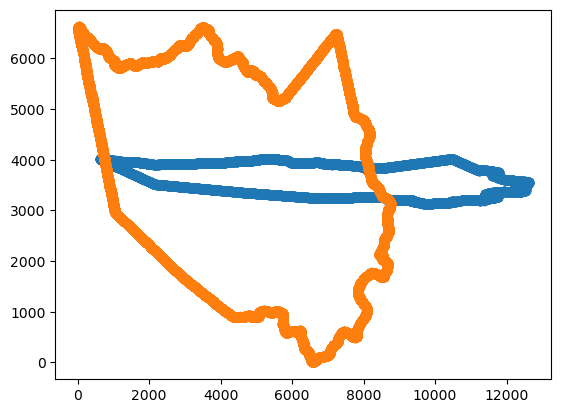

[[ 5.91302651e+14  1.96293253e+14]
 [-2.01408970e+17 -6.77197852e+16]
 [ 1.00000000e+00  1.00000000e+00]]
[[-3.81651592e+10  1.31842254e+09  5.91302651e+14]
 [ 1.29168295e+13 -8.25898037e+10 -2.01408970e+17]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48201CIND0E.tif


  0%|          | 0/6 [00:00<?, ?it/s]

[1.908496732026144, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.6666666666666665, 2.5667412378821775, 0.16, 0.0299625468164794, 0.07575757575757576, 0.4393939393939394, 0.2814814814814815, 0.3607843137254902, 0.2962962962962963, 0.32558139534883723, 2.3851851851851853, 2.9363295880149813, 3.1818181818181817, 0.6515151515151515, 0.9185185185185185, 0.23255813953488372, 0.6814814814814815, 0.8837209302325582, 0.3484848484848485, 1.312145289443814, 0.17708333333333334, 0.0, 0.06060606060606061, 0.1839080459770115, 0.43956043956043955, 0.3607843137254902, 0.8, 0.3875968992248062, 0.37037037037037035, 0.4344569288389513, 0.48484848484848486, 0.22988505747126436, 0.6666666666666666, 0.22988505747126436, 0.6074074074074074, 0.6431372549019

____________________________________
['f', '48201', 'C0295M', '619', '2014', '3USH', '__', 'CITY', 'TAL', 'AIRPORT', 'HUME', '48201', 'CO485M', '6', '9', '2014']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((6536.995839027431 2897.727907815763, 6548.000000000001 2295, 6030.172606159411 2285.545889904985, 6019.004144937993 2897.272970441716, 6536.995839027431 2897.727907815763)), POLYGON ((6019.004144937993 2897.272970441716, 6008 3500, 6525.82739384059 3509.454110095015, 6536.995839027431 2897.727907815763, 6019.004144937993 2897.272970441716)))
____________________________________
['R', '48201C0290N', '19', '2014', 'GEORGE', 'B', 'INTERCONTINENT', '48201C0480M', '6', '9', '2014']
Found too many names! Splitting along longest sides
GEOMETRYCOLLECTION (POLYGON ((5497.49479050092 2897.273158951754, 5486 3500, 6006.829637826339 3509.932903540635, 6018.505192860629 2897.727713481819, 5497.49479050092 2897.273158951754)), POLYGON ((6018.505192860629 2897.

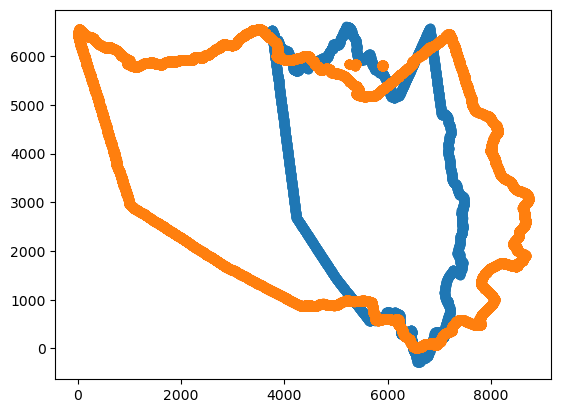

[[-1.05416507e+07 -9.99665103e+06]
 [ 3.48319379e+06  3.38916865e+06]
 [ 1.00000000e+00  1.00000000e+00]]
[[ 5.26569714e+01 -2.03867395e+01 -1.05416507e+07]
 [-9.08455456e+00 -1.94451209e+01  3.48319379e+06]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
C:\Users\fhacesga\Desktop\FIRMsDigitizing\processing\2023-10-20_11-05-37\\Inputs\48201CIND0F.tif


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
verbose = True

TPNN = None
RLNN = None
CLNN = None

for i, row in index_files.iterrows():
    print(row["FilePath"])
    
    filename = os.path.basename(row["FilePath"])
    
    # READ FILES AND RUN CLASSIFICATIONS
    image = cv2.imread(row["FilePath"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # SAVE IMAGE TO OUTPUT DIRECTORY
    output_image = os.path.join(outputs_dir, filename)
    copyfile(row["FilePath"], output_image)
    
    # GET BOUNDARY POINTS FROM RESPECTIVE SHAPEFILE
    point_boundary_gdf, shp_bounds = getBoundaryPoints(row, distance=100)
    if point_boundary_gdf is None:
        continue
    
    # WHAT ARE WE LOOKING FOR IN EACH IDENTIFIED SQUARE?
    key = findKey(row["Basename"])    
    if key is None:
        print(f"Could not find key in {filename}")
        
    # data_dir = r"C:\\Users\\fhace\\OneDrive - University Of Houston\\AAA_RECTDNN\\data\\"
        
    # RUN IMAGES THROUGH CNNs
    classifications, TPNN  = findKeypoints(image, model=TPNN)
    effectiveArea, RLNN    = findSquares(image, model=RLNN)
    countyArea, CLNN       = findCounty(image, model=CLNN)
    
    cv2.imwrite(f"tempfiles/{filename}_00_classification.png", np.asarray(probability_to_rgb(classifications)))
    cv2.imwrite(f"tempfiles/{filename}_00_effectiveArea.png", np.asarray(probability_to_rgb(effectiveArea)))
    cv2.imwrite(f"tempfiles/{filename}_00_county.png", np.asarray(probability_to_rgb(countyArea)))
    
    # FIND THE GRID INSIDE THE IMAGE
    out = FindGrid(image, classifications, effectiveArea, key, row["FilePath"], verbose=True)
    
    # PLOT IMAGE
    plot_image = np.dstack([image, image, image])
    contours = []
    
    # LOOP THROUGH CONTOURS AND ADD THEM TO IMAGE
    for k, v in out.items():
        cv2.drawContours(plot_image, v, -1, (0, 255, 0), 3)
        contours.append(contours_to_shapely_polygons(v))
        
    if len(contours) == 0:
        
    # CALCULATE BOUNDS OF CONTOURS ON IMAGE
    bounds_panels = MultiPolygon(contours).bounds
    bounds_panels = [int(i) for i in bounds_panels]

    # CREATE MASK USING GRID 
    mask = np.zeros(image.shape)
    mask[bounds_panels[1]:bounds_panels[3], bounds_panels[0]:bounds_panels[2]] = 1
    mask_1 = drawGrid(image, out)            # GRID MASKING
    mask_2 = classifications[:, :, 1]        # CLASSIFICATIONS MAPPING
    mask   = np.logical_and(~mask_1, mask)   # MERGE MASKS
    mask   = np.logical_and(mask_2, mask)
    
    def translation_matrix(x, y, z=1):
        matrix = np.array([[1, 0, x],
                           [0, 1, y],
                           [0, 0, z]])
        return matrix
        
    
    # FLIP IMAGE AND MASK IT
    image = 255 - image
    image_t = image * mask
    
    # RASTER BOUNDS
    get_bounds_image = np.where(np.asarray(cv2.erode(image_t, np.ones((3,3), np.uint8)) > 50), 1, 0)
    # plt.imshow(get_bounds_image)
    # plt.show()
    
    # print(get_bounds_image)
    bounds_panels_postfilter = find_bbox(get_bounds_image)
    bounds_panels = [i for i in bounds_panels_postfilter]

    print("Assigning Points")
    # INITIAL TRANSFORM
    from_points   = np.array([[bounds_panels[0], bounds_panels[1]], 
                   [bounds_panels[0], bounds_panels[3]],
                   [bounds_panels[2], bounds_panels[1]],
                   [bounds_panels[2], bounds_panels[3]]])

    to_points = np.array([[shp_bounds[0], shp_bounds[1]], 
                   [shp_bounds[0], shp_bounds[3]],
                   [shp_bounds[2], shp_bounds[1]],
                   [shp_bounds[2], shp_bounds[3]]])

    initial_transform = cv2.findHomography(from_points, to_points, cv2.RANSAC, 1000)
    original_homography = initial_transform[0]
    inverse_transform = np.linalg.inv(original_homography)

    # CONVERT THINNED IMAGE TO POINTS
    thin_image = getCountyBoundaryFromImage(countyArea)
    # cv2.ximgproc.thinning(image_t.astype(np.uint8), thinningType=cv2.ximgproc.THINNING_GUOHALL)
    y, x = np.where(thin_image[::-1, :])                   # GET COORDINATES OF EVERY 
    image_points = np.vstack((x, y, np.ones(x.shape)))     # STACK X, Y, AND Z COORDINATES
    # outputs = original_homography @ image_points           # TRANSFORM COORDINATES USING ESTIMATES
    
    # TRANSFORM SHAPEFILE POINTS INTO IMAGE COORDINATE SYSTEM
    point_geometry = [[point.geometry.x, point.geometry.y, 1] for i, point in point_boundary_gdf.iterrows()]
    point_geometry = inverse_transform @ np.array(point_geometry).T
    
    # COORDINATE HANDLING
    coords_shp = point_geometry.T
    coords_ras = np.vstack((image_points[0, :], image_points[1, :], np.ones(image_points[1, :].shape))).T
    
    # IMAGE ORIGIN COORDINATE SYSTEM TO IMAGE CENTER COORDINATE SYSTEM
    offsets = np.min(coords_ras, axis=0)
    print(offsets)
    x_offset = offsets[0]
    y_offset = offsets[1]
    
    # TRANSLATION VECTOR
    offset_matrix = translation_matrix(x_offset, y_offset)

    coords_shp_proc_bl = np.vstack((coords_shp[:, 0] - x_offset, coords_shp[:, 1] - y_offset)).T
    coords_ras_proc_bl = np.vstack((coords_ras[:, 0] - x_offset, coords_ras[:, 1] - y_offset)).T
    
    plt.scatter(coords_shp_proc_bl[:, 0], coords_shp_proc_bl[:, 1])
    plt.scatter(coords_ras_proc_bl[:, 0], coords_ras_proc_bl[:, 1])
    plt.show()
    
    # FAST SEARCH STRUCTURE
    kdtree     = cKDTree(coords_ras_proc_bl)
    
    # ITERATIVE CLOSEST POINT
    reprojected_points = []
    compounded_homography = np.eye(3)
    proc_points = coords_shp_proc_bl
    
    rotation=True
    shear=False
    perspective=False
    
    plot=False
    
    transforms = []
    grades     = []
    
    # ITERATE
    for i in tqdm(range(50), disable=True):
        
        _, nearest_indices = kdtree.query(proc_points)
        to_points = np.array([coords_ras_proc_bl[idx] for idx in nearest_indices])
        
        # TAKE ADJUSTMENT STEP
        new_homography = adjustStep_affine(proc_points, coords_ras_proc_bl, kdtree,
                                        shear=shear, rotation=rotation, perspective=perspective)
        
        if plot:
            fig, ax = plt.subplots()
            ax.scatter(proc_points[:, 0], proc_points[:, 1])
            ax.scatter(coords_ras_proc_bl[:, 0], coords_ras_proc_bl[:, 1])
            ax.scatter(to_points[:, 0], to_points[:, 1])

            for i in tqdm(range(proc_points.shape[0])):
                # print(proc_points[i, 0], proc_points[i, 1], to_points[i, 0], to_points[i, 1])
                plt.plot([proc_points[i, 0], to_points[i, 0]],
                         [proc_points[i, 1], to_points[i, 1]], 'ko', linestyle="--")
            plt.show()
        
        transform = new_homography.copy()
        
        # APPLY TRANSFORM FROM ADJUSTMENT TO PROCESSING POINTS AND APPEND TO LIST
        reprojected_points.append(applyTransform(transform, proc_points))
        
        proc_points = applyTransform(transform, proc_points)
        if plot:
            plt.scatter(proc_points[:, 0], proc_points[:, 1])
            plt.scatter(coords_ras_proc_bl[:, 0], coords_ras_proc_bl[:, 1])
            plt.scatter(to_points[:, 0], to_points[:, 1])
            plt.show()
            
        # COMPOUND TRANSFORMATION
        compounded_homography = compounded_homography @ transform
        
        transforms.append(compounded_homography)
        
        def gradeFit(pts1, kdtree):
            dist, _ = kdtree.query(pts1)
            return np.sqrt(np.sum(dist ** 2))
        
        grades.append(gradeFit(proc_points, kdtree))
        
        
        if i % 1 == 0:
            scale  = np.sqrt((new_homography[0, 0] ** 2 + new_homography[1, 1] ** 2) / 2)
            offset = np.sqrt((new_homography[1, 2] ** 2 + new_homography[0, 2] ** 2) / 2)
            # print(f"Scale: {scale:.2f} Offset: {offset:.2f}")
    
    best_transform = transforms[np.argmin(grades)]
    best_points    = reprojected_points[np.argmin(grades)]
    
    if plot:
        plt.plot(range(len(grades)), grades)
        plt.scatter(np.argmin(grades), grades[np.argmin(grades)])
        plotICP(reprojected_points, plot_skip=10, )
        plt.show()
    
    # REVERSE Y AXIS
    rev_y_axis = np.array([[1, 0, 0],
                           [0,-1, 0],
                           [0, 0, 1]])

    # move = original_homography @ np.array([0, image_t.shape[0], 0])
    translation = np.eye(3)
    translation[1, 2] = image_t.shape[0]
    
    # adjustment = asymetric_adjustment @ symetric_adjustment
    adjustment =  np.linalg.inv(best_transform.copy())

    # rev_adj = rev_y_axis @ adjustment
    rev_adj = adjustment.copy()
    rev_adj[1, 1] = rev_adj[1, 1] * -1
    
    output_transform = original_homography @ translation @ rev_adj
    # output_transform[1, 1] = output_transform[1, 1] * -1
    offsets = output_transform @ np.array([[0, 0, 1], [image.shape[0], 0, 1]]).T
    print(offsets)
    offsets = offsets[:, 1] - offsets[:, 0]
    # output_transform[0, 1] = -1 * output_transform[0, 1]

    print(output_transform)
    output_affine = Affine(*output_transform.flatten()[:6])
    write_world_file_from_affine(output_affine, get_world_file_path(output_image))

In [ ]:
bounds_panels

In [ ]:
rev_adj

In [ ]:
plt.scatter(best_points[:, 0], best_points[:, 1], s=1)
plt.scatter(coords_ras_proc_bl[:, 0], coords_ras_proc_bl[:, 1], s=1)